# 迁移学习

- 当我们需要训练一个新的分类任务，我们不会完全从一个随机的模型开始训练，而是利用好 预训练 的模型来加速训练的过程。 在图像分类任务中经常使用 ImageNet作为与训练的模型。
- 迁移学习是一种使用 transfer learning 的方法，常用以下两种方法做迁移学习。
 - fine turning ：从一个预训练模型开始，我们改变一些模型的架构（改变输入层、输出层结构，如在输出层末尾接全连接层），然后继续训练整个模型的参数。
 - feature extraction ：我们不改变预训练模型的参数，而是只更新我们改变过的部分模型的参数，即将预训练模型当作特征提取器。之所以叫 feature extraction 也是因为我们把预训练模型当作特征提取模型，利用提取出来的特征完成我们的训练任务。

<br>构建和训练迁移模型的基本步骤：
- 初始化预训练模型
- 把最后一层输出层改变成我们想要的分类总数
- 定义一个 optimizer 来更新参数
- 模型训练

数据
------

我们会使用*hymenoptera_data*数据集，[下载](https://download.pytorch.org/tutorial/hymenoptera_data.zip).

这个数据集包括两类图片, **bees** 和 **ants**, 这些数据都被处理成了可以使用`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`来读取的格式。我们只需要把``data_dir``设置成数据的根目录，然后把``model_name``设置成我们想要使用的与训练模型：
::
   [resnet, alexnet, vgg, squeezenet, densenet, inception]

其他的参数有：
- ``num_classes``表示数据集分类的类别数
- ``batch_size``
- ``num_epochs``
- ``feature_extract``表示我们训练的时候使用fine tuning还是feature extraction方法。如果``feature_extract = False``，整个模型都会被同时更新。如果``feature_extract = True``，只有模型的最后一层被更新。

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import time
import os
import copy
print("Torchvision Version: ",torchvision.__version__)

Torchvision Version:  0.4.0


### 1、查看数据

In [9]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./hymenoptera_data"
# Batch size for training (change depending on how much memory you have)
batch_size = 32
input_size = 224


#os.path.join() 连接路径，相当于.../data_dir/train
all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"),
                                transforms.Compose([
        transforms.RandomResizedCrop(input_size), #把每张图片变成resnet需要输入的维度224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(all_imgs, batch_size=batch_size, shuffle=True, num_workers=4)
#训练数据分batch，变成tensor迭代器

In [10]:
img = next(iter(loader))[0] #这个img是一个batch的tensor
img.shape

torch.Size([32, 3, 224, 224])

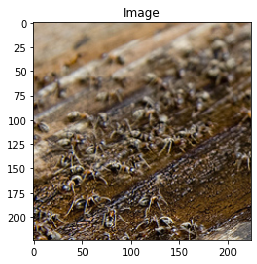

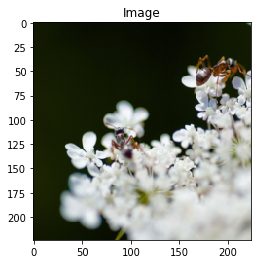

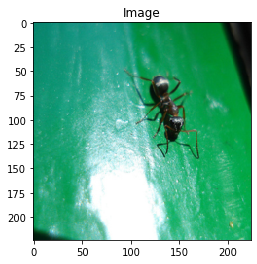

In [11]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
#transforms：torchvision的子模块，常用的图像操作
#.ToPILImage() 把tensor或数组转换成图像
#详细转换过程可以看这个：https://blog.csdn.net/qq_37385726/article/details/81811466

plt.ion() #交互模式，默认是交互模式，可以不写
#详细了解看这个：https://blog.csdn.net/SZuoDao/article/details/52973621
#plt.ioff()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension 
    #这个.squeeze(0)看不懂，去掉也可以运行
    
    image = unloader(image) #tensor转换成图像
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(1) # pause a bit so that plots are updated
    #可以去掉看看，只是延迟显示作用


plt.figure()
imshow(img[8], title='Image') 
imshow(img[9], title='Image')
imshow(img[10], title='Image')

### 2、将数据集分为训练集和测试集
现在我们知道了模型输入的size，我们就可以把数据预处理成相应的格式

In [12]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        #数据进行normalization 是求取数据集的平均值和标准差 这样有利于模型训练
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size), # 与train不同处
        transforms.CenterCrop(input_size),# 与train不同处
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")


# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
#把迭代器存放到字典里作为value，key是train和val，后面调用key即可。

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [13]:
inputs, labels=next(iter(dataloaders_dict["train"])) #一个batch
print(inputs.shape)
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1])


In [14]:
for inputs, labels in dataloaders_dict["train"]:
    #print(inputs)
    #print(labels)
    print(labels.size()) #最后一个batch不足32

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([20])


### 3、加载 restnet 预训练模型，并修改最后的连接层

In [17]:
''' 查看rest net 模型'''
model_ft = models.resnet18()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
model_ft.fc #查看最后一层 fc 层的结构

Linear(in_features=512, out_features=1000, bias=True)

In [48]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
# Number of classes in the dataset
num_classes = 2
# Number of epochs to train for 
num_epochs = 5
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True  #只更新修改的层

In [22]:
def set_parameter_requires_grad(model, fature_extract):
    ''' 如果是 fature extract 模型的参数就不需要梯度更新 '''
    if fature_extract:
        for param in model.parameters():
            param.requires_grad = False

In [25]:
def initialize_model(model_name, num_classess, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained) #如果use_pretrained 是 True，从imagenet上返回预训练的模型和参数
        
        set_parameter_requires_grad(model_ft, feature_extract) # 设置是否更新模型的参数
        
        num_ftrs = model_ft.fc.in_features # 获取最后一层 fc 层的输入维度
        model_ft.fc = nn.Linear(num_ftrs, num_classess) # 重新设置模型的最后的 fc 层结构
        
        input_size = 224
        
        return model_ft, input_size
    else: 
        print("model not implemented")
        return None, None
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained = True)

In [26]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
model_ft.fc.weight.requires_grad # 因为模型的参数的 require grad 都已经设置成 False 了。最后一层是之后重新修改的，所以只有最后一层是 True

True

### 4、定义训练模型

In [40]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    val_acc_history = [] 
    for epoch in range(num_epochs):
        
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print("-"*10)
        
        for phase in ["train","val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase == "train"): # 根据 phase 自动决定是否更新梯度
                    outputs = model(inputs) # dimension = batch size * 2
                    loss = loss_fn(outputs, labels)
                
                preds = outputs.argmax(dim=1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0) # 因为 loss 是平均过的 所以 这里要乘上 数量
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item() # view 设置成 -1 就是说所有的数据全部展开
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            print("phase {} loss:{},acc:{}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)
    model.load_state_dict(best_model_wts) #把最新的参数复制到model中
    return model,val_acc_history

### 5、运行训练模型

In [36]:
model_ft = model_ft.to(device)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 0.001, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

In [49]:
_,model_history = train_model(model_ft, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Epoch 0/4
----------
phase train loss:0.29156394864692065,acc:0.8975409836065574
phase val loss:0.281592879225226,acc:0.934640522875817
Epoch 1/4
----------
phase train loss:0.29459429202509707,acc:0.9098360655737705
phase val loss:0.28030378522436605,acc:0.9411764705882353
Epoch 2/4
----------
phase train loss:0.2715431744935083,acc:0.9139344262295082
phase val loss:0.2827546590683507,acc:0.934640522875817
Epoch 3/4
----------
phase train loss:0.2721141737992646,acc:0.9098360655737705
phase val loss:0.2830793771868438,acc:0.9411764705882353
Epoch 4/4
----------
phase train loss:0.249498081500413,acc:0.9385245901639344
phase val loss:0.28189076512467626,acc:0.9411764705882353


#### 作为对比 不使用预训练的 参数

In [44]:
model_scratch, _ = initialize_model(model_name, num_classes, feature_extract= False, use_pretrained = False)
model_scratch = model_scratch.to(device)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model_scratch.parameters()), lr = 0.001, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

In [50]:
_,scratch_history = train_model(model_scratch, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Epoch 0/4
----------
phase train loss:0.6404627092549058,acc:0.5942622950819673
phase val loss:0.6391796719015034,acc:0.6405228758169934
Epoch 1/4
----------
phase train loss:0.6174807177215326,acc:0.6557377049180327
phase val loss:0.6293005016114976,acc:0.6405228758169934
Epoch 2/4
----------
phase train loss:0.6121863986625046,acc:0.6311475409836066
phase val loss:0.6024808435658224,acc:0.7058823529411765
Epoch 3/4
----------
phase train loss:0.6073156595230103,acc:0.639344262295082
phase val loss:0.5856732718305651,acc:0.7124183006535948
Epoch 4/4
----------
phase train loss:0.6171747651256498,acc:0.6557377049180327
phase val loss:0.5664196053361581,acc:0.7189542483660131


### 画图

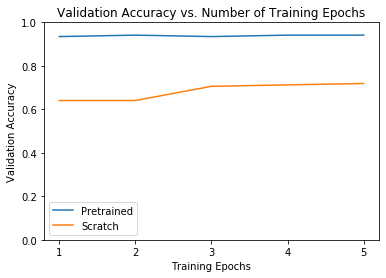

In [51]:

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
# ohist = []
# shist = []

# ohist = [h.cpu().numpy() for h in ohist]
# shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),model_history,label="Pretrained")
plt.plot(range(1,num_epochs+1),scratch_history,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

- Elmo 模型在 github 中找 Elmo allennlp

- Bert 模型 GitHub 中找 huggingface 使用pytorch实现的 bert 模型，Bert模型本身是使用tensorflow实现的